In [1]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definition of a single linear attention unit for linear-regression data
# P is the value matrix
# Q is the product of key,query matrices
# the dimensions of the input are
# B: batch-size of prompts
# N: context length (excluding query)
# d: covariate dimension
# P,Q are d x d matrices
# Z is a B x (N+1) + (d+1) matrix
# Output is also B x (N+1) + (d+1)

# For linear attention, activation = None
# For standard attention, activation(x) = torch.nn.functional.softmax(x, dim = 2)
# For ReLU attention, activation(x) = torch.nn.relu(x)
def attention(P,Q,Z, activation = None):
    B= Z.shape[0]
    N = Z.shape[1]-1
    d = Z.shape[2]-1
    P_full =  torch.cat([P,torch.zeros(1,d).to(device)],dim=0)
    P_full =  torch.cat([P_full,torch.zeros(d+1,1).to(device)],dim=1)
    P_full[d,d] = 1
    Q_full = torch.cat([Q, torch.zeros(1,d).to(device)],dim=0)
    Q_full = torch.cat([Q_full, torch.zeros(d+1,1).to(device)],dim=1)
    A = torch.eye(N+1).to(device)
    A[N,N] = 0
    Attn = torch.einsum('BNi, ij, BMj -> BNM', (Z,Q_full,Z))
    if activation is not None:
        Attn = activation(Attn)
    key = torch.einsum('ij, BNj -> BNi', (P_full,Z))
    Output = torch.einsum('BNM,ML, BLi -> BNi', (Attn,A,key))
    return Output /N


# The Linear Transformer module
# n_layer denotes the number of layers
# n_head denotes the number of heads. In most of our experiments, n_head = 1
# d denotes the dimension of covariates
# var denotes the variance of initialization. It needs to be sufficiently small, but exact value is not important
# allparam: contains all the parameters, has dimension n_layer x n_head x 2 x d x d
# For example
# - P matrix at layer i, head j is allparam[i,j,0,:,:]
# - Q matrix at layer i, head j is allparam[i,j,1,:,:]
class Transformer_F(nn.Module):
    def __init__(self, n_layer, n_head, d, var):
        super(Transformer_F, self).__init__()
        self.register_parameter('allparam', torch.nn.Parameter(torch.zeros(n_layer, n_head, 2, d, d)))
        with torch.no_grad():
            self.allparam.normal_(0,var)
        self.n_layer = n_layer
        self.n_head = n_head

    def forward(self, Z):
        for i in range(self.n_layer):
            Zi = Z
            residues = 0
            # the forwarad map of each layer is given by F(Z) = Z + attention(Z)
            for j in range(self.n_head):
                Pij = self.allparam[i,j,0,:,:]
                Qij = self.allparam[i,j,1,:,:]
                residues = residues + attention(Pij,Qij,Zi)
            Z = Zi + residues
        return Z
    
    #enforces top-left-dxd-block sparsity on p
    def zero_p(self):
        for i in range(self.n_layer):
            for j in range(self.n_head):
                with torch.no_grad():
                    self.allparam[i,j,0,:,:].zero_()

class Transformer_MLP_freeze(nn.Module):
    def __init__(self, n_layer, n_head, d, var, randomMLP):
        super(Transformer_MLP_freeze, self).__init__()
        self.register_parameter('allparam', torch.nn.Parameter(torch.zeros(n_layer, n_head, 2, d, d)))
        with torch.no_grad():
            self.allparam.normal_(0,var)
        self.n_layer = n_layer
        self.n_head = n_head
        self.randomMLP = randomMLP

    def forward(self, Z):
        Z[:,:,:-1] = self.randomMLP(Z[:,:,:-1])
        for i in range(self.n_layer):
            Zi = Z
            residues = 0
            # the forwarad map of each layer is given by F(Z) = Z + attention(Z)
            for j in range(self.n_head):
                Pij = self.allparam[i,j,0,:,:]
                Qij = self.allparam[i,j,1,:,:]
                residues = residues + attention(Pij,Qij,Zi)
            Z = Zi + residues
        return Z

class Transformer_MLP(nn.Module):
    def __init__(self, n_layer, n_head, d, var, hidden_dim):
        super(Transformer_MLP, self).__init__()
        self.register_parameter('allparam', torch.nn.Parameter(torch.zeros(n_layer, n_head, 2, d, d)))
        with torch.no_grad():
            self.allparam.normal_(0,var)
        self.n_layer = n_layer
        self.n_head = n_head
        self.mlp = nn.Sequential(nn.Linear(d, hidden_dim),nn.ReLU(),nn.Linear(hidden_dim, d))

    def forward(self, Z):
        Z[:,:,:-1] = self.mlp(Z[:,:,:-1].clone())
        for i in range(self.n_layer):
            Zi = Z
            residues = 0
            # the forwarad map of each layer is given by F(Z) = Z + attention(Z)
            for j in range(self.n_head):
                Pij = self.allparam[i,j,0,:,:]
                Qij = self.allparam[i,j,1,:,:]
                residues = residues + attention(Pij,Qij,Zi)
            Z = Zi + residues
        return Z

# evaluate the loss of model, given data (Z,y)
def in_context_loss(model, Z, y):
    N = Z.shape[1]-1
    d = Z.shape[2]-1
    output = model(Z)
    diff = output[:,N,d]+y
    loss = ((diff)**2).mean() 
    return loss

def generate_data_mlp(N, B, d, randomMLP):
    # Generate random input data
    X = torch.FloatTensor(B, N, d).normal_(0, 1).to(device)
    X_test = torch.FloatTensor(B, 1, d).normal_(0, 1).to(device)

    # Additional transformations if mode is 'sphere' or 'gamma' [Similar to the existing generate_data function]

    X_MLP = randomMLP(X.view(-1, d)).view(B, N, d)
    X_test_MLP = randomMLP(X_test.view(-1, d)).view(B, 1, d)

    W = torch.FloatTensor(B, d).normal_(0,1).cuda()
    y = torch.einsum('bi,bni->bn', (W, X_MLP)).unsqueeze(2)
    y_zero = torch.zeros(B,1,1).cuda()
    y_test = torch.einsum('bi,bni->bn', (W, X_test_MLP)).squeeze(1)
    X_comb= torch.cat([X,X_test],dim=1)
    y_comb= torch.cat([y,y_zero],dim=1)
    Z= torch.cat([X_comb,y_comb],dim=2)

    return Z, y_test


Extended Training with adam optimizer, Learning Rate: 0.01
Epoch 0, Loss: 0.8977972865104675
Epoch 100, Loss: 0.06529568880796432
Epoch 200, Loss: 0.049261003732681274
Epoch 300, Loss: 0.03302786499261856
Epoch 400, Loss: 0.0272568017244339
Epoch 500, Loss: 0.02614627778530121
Epoch 600, Loss: 0.01723528653383255
Epoch 700, Loss: 0.01620742306113243
Epoch 800, Loss: 0.01916106417775154
Epoch 900, Loss: 0.012859604321420193
Epoch 1000, Loss: 0.013284420594573021
Epoch 1100, Loss: 0.012503384612500668
Epoch 1200, Loss: 0.013444550335407257
Epoch 1300, Loss: 0.011920204386115074
Epoch 1400, Loss: 0.011852702125906944
Epoch 1500, Loss: 0.01124937366694212
Epoch 1600, Loss: 0.012562590651214123
Epoch 1700, Loss: 0.011931401677429676
Epoch 1800, Loss: 0.012086574919521809
Epoch 1900, Loss: 0.010339601896703243
Epoch 2000, Loss: 0.011604543775320053
Epoch 2100, Loss: 0.01217163261026144
Epoch 2200, Loss: 0.013576262630522251
Epoch 2300, Loss: 0.012556668370962143
Epoch 2400, Loss: 0.013721881

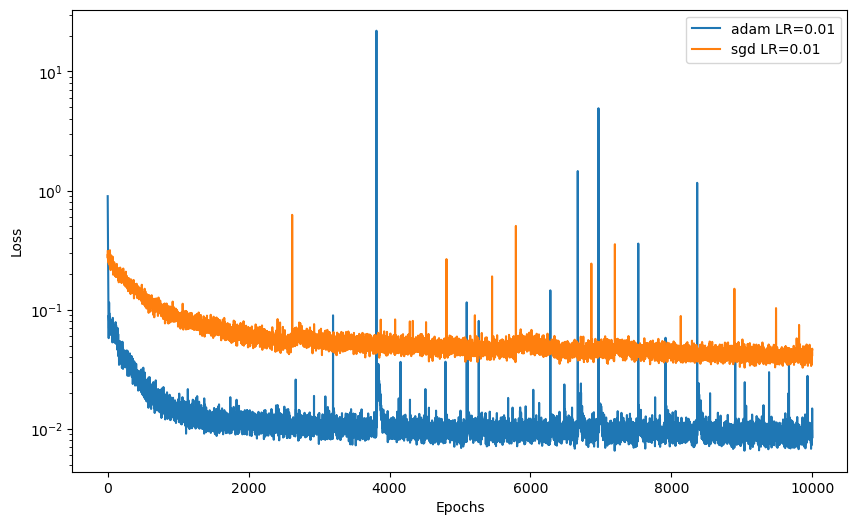

In [6]:
# Setup
N=20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_layer = 3  # number of layers of transformer
d = 5        # dimension for sine data
n_head = 1   # 1-headed attention
B = 1000     # minibatch size for sine data
var = 0.0001 # initializations scale of transformer parameter
max_iters = 10000  # Number of Iterations to run
hidden_dim = 5
optimal_lr = {'adam': 0.01, 'sgd': 0.01}

# Function to run training
def train_transformer(optimizer_name, learning_rate, max_epochs):
    randomMLP = nn.Sequential(nn.Linear(d, hidden_dim),nn.ReLU(),nn.Linear(hidden_dim, d)).to(device)
    for para in randomMLP.parameters():
        para.requires_grad = False
    # Initialize model and optimizer
    # model = Transformer_MLP(n_layer, n_head, d, var, hidden_dim).to(device)
    model = Transformer_MLP_freeze(n_layer, n_head, d, var, randomMLP).to(device)
    if optimizer_name == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_name == 'adam':
        optimizer = torch.optim.Adam([model.allparam], lr=learning_rate, betas=(0.9, 0.9))

    losses = []
    for epoch in range(max_epochs):
        # Generate data
        Z, y = generate_data_mlp(N=N, B=B, d=d, randomMLP=randomMLP)
        Z, y = Z.to(device), y.to(device)

        # Training step
        optimizer.zero_grad()
        loss = in_context_loss(model, Z, y)
        loss.backward()
        optimizer.step()

        # Record loss
        losses.append(loss.item())

        # Optionally print progress
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return losses

# Tuning learning rate
'''tuning_epochs = 200
optimal_lr = {}
for optimizer_name in ['adam']:
    best_lr = None
    best_loss = float('inf')
    for lr in learning_rates:
        print(f"Training with {optimizer_name} optimizer, Learning Rate: {lr}")
        losses = train_transformer(optimizer_name, lr, tuning_epochs)
        avg_loss = np.mean(losses[-20:])  # Average loss over last epochs
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_lr = lr
    optimal_lr[optimizer_name] = best_lr
    print(f"Optimal Learning Rate for {optimizer_name}: {best_lr}")
'''

# Extended training with optimal learning rates
final_losses = {}
for optimizer_name, lr in optimal_lr.items():
    print(f"Extended Training with {optimizer_name} optimizer, Learning Rate: {lr}")
    losses = train_transformer(optimizer_name, lr, max_iters)
    final_losses[optimizer_name] = losses

# Plotting losses
plt.figure(figsize=(10, 6))
for optimizer_name, losses in final_losses.items():
    plt.plot(losses, label=f'{optimizer_name} LR={optimal_lr[optimizer_name]}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()